In [1]:

import sys
import os
os.listdir('../sequence_uncertainty')


['__pycache__', 'gpt2.py']

In [2]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import sys

import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

sys.path.append("..")
from sequence_uncertainty.gpt2 import GPTConfig, GPT

# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out-shakespeare'
log_interval = 10
# eval_interval = 250
# eval_iters = 200
eval_interval = 100
eval_iters = 100
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = False # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_log = False # disabled by default
wandb_project = 'owt'
wandb_run_name = 'gpt2' # 'run' + str(time.time())
# data
dataset = 'shakespeare_char'
gradient_accumulation_steps = 1 # used to simulate larger batch sizes
batch_size = 64 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 256
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 5000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.99
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 100 # how many steps to warm up for
# lr_decay_iters = 5000
lr_decay_iters = max_iters
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = False # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------


In [3]:
# various inits, derived attributes, I/O setup
master_process = True
seed_offset = 0
ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# poor man's data loader
data_dir = os.path.join('../data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y



tokens per iteration will be: 16,384


In [4]:
# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line
# init a new model from scratch
print("Initializing a new model from scratch")
# determine the vocab size we'll use for from-scratch training
if meta_vocab_size is None:
    print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)

# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        el_losses = []
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()

            ############### elementwise losses

            with torch.no_grad():
                by_element = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), reduce=False)
                by_element = by_element.view(Y.shape).mean(axis=0)
                el_losses.append(by_element)

            ###############
        out[split] = losses.mean()
        out[f"{split}_token"] = torch.stack(el_losses).mean(0)
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model # unwrap DDP container if needed
running_mfu = -1.0

train_losses = []
val_losses = []
train_token_losses = []
val_token_losses = []




while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        train_token_losses.append(losses['train_token'])
        val_token_losses.append(losses['val_token'])
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)
Initializing a new model from scratch
number of parameters: 10.65M
using fused AdamW: True


/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


step 0: train loss 4.2881, val loss 4.2821
iter 0: loss 4.2693, time 4697.26ms, mfu -100.00%
iter 10: loss 3.2331, time 48.10ms, mfu 7.75%
iter 20: loss 2.8214, time 50.10ms, mfu 7.72%
iter 30: loss 2.6330, time 48.39ms, mfu 7.71%
iter 40: loss 2.5595, time 47.86ms, mfu 7.72%
iter 50: loss 2.5243, time 48.77ms, mfu 7.71%
iter 60: loss 2.5189, time 47.98ms, mfu 7.72%
iter 70: loss 2.4786, time 48.63ms, mfu 7.71%
iter 80: loss 2.4819, time 47.76ms, mfu 7.72%
iter 90: loss 2.4902, time 48.51ms, mfu 7.72%
step 100: train loss 2.4483, val loss 2.4652
saving checkpoint to out-shakespeare
iter 100: loss 2.4585, time 4293.99ms, mfu 6.95%
iter 110: loss 2.4541, time 48.93ms, mfu 7.02%
iter 120: loss 2.4272, time 48.56ms, mfu 7.09%
iter 130: loss 2.4130, time 48.65ms, mfu 7.14%
iter 140: loss 2.4205, time 48.49ms, mfu 7.20%
iter 150: loss 2.4151, time 47.93ms, mfu 7.26%
iter 160: loss 2.3799, time 48.40ms, mfu 7.30%
iter 170: loss 2.3807, time 50.34ms, mfu 7.31%
iter 180: loss 2.3362, time 49.59

In [5]:
num_samples = 5
start = "\n"
max_new_tokens = 100
temperature = 1.0
top_k = 10

def sample():
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    start_ids = encode(start)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
                print(decode(y[0].tolist()))
                print('---------------')
sample()


Loading meta from ../data/shakespeare_char/meta.pkl...

Clown:
You might emporal have we some flattered words, not not bear.
The sun you have delight them t
---------------

At my father, I will make myself
Perchance our manners as we should put upon.

KING RICHARD II:
What
---------------

Where of your grace have been slain upon 's:
So prospern lawful we behind your grace
Hath been loss 
---------------

think my daughter fight to die?

QUEEN ELIZABETH:
So look'd you call the suit of my son,
And give yo
---------------

Looking like some advantage ore other,
Too wish, but to work occident in the earth,
On what cause I 
---------------


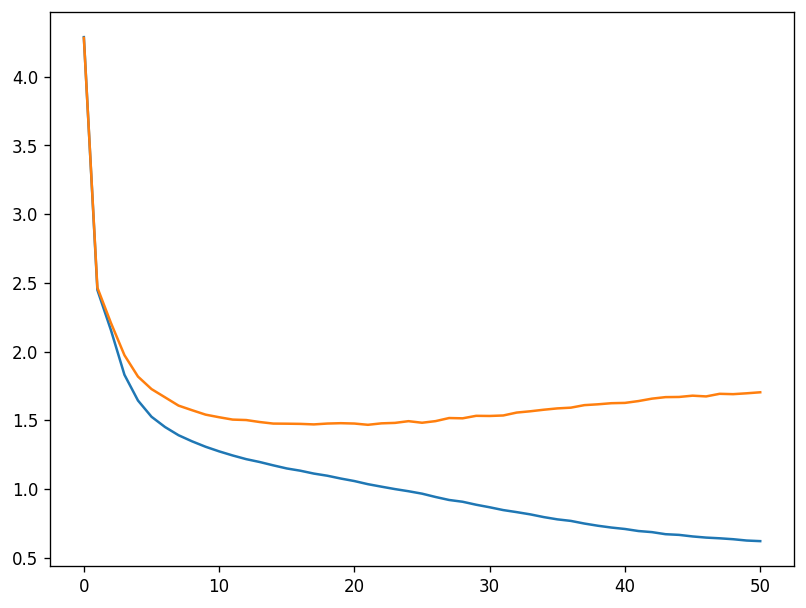

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=120)
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [7]:
train_token_losses = torch.stack(train_token_losses).detach().cpu().float()
val_token_losses = torch.stack(val_token_losses).detach().cpu().float()
# train_token_losses



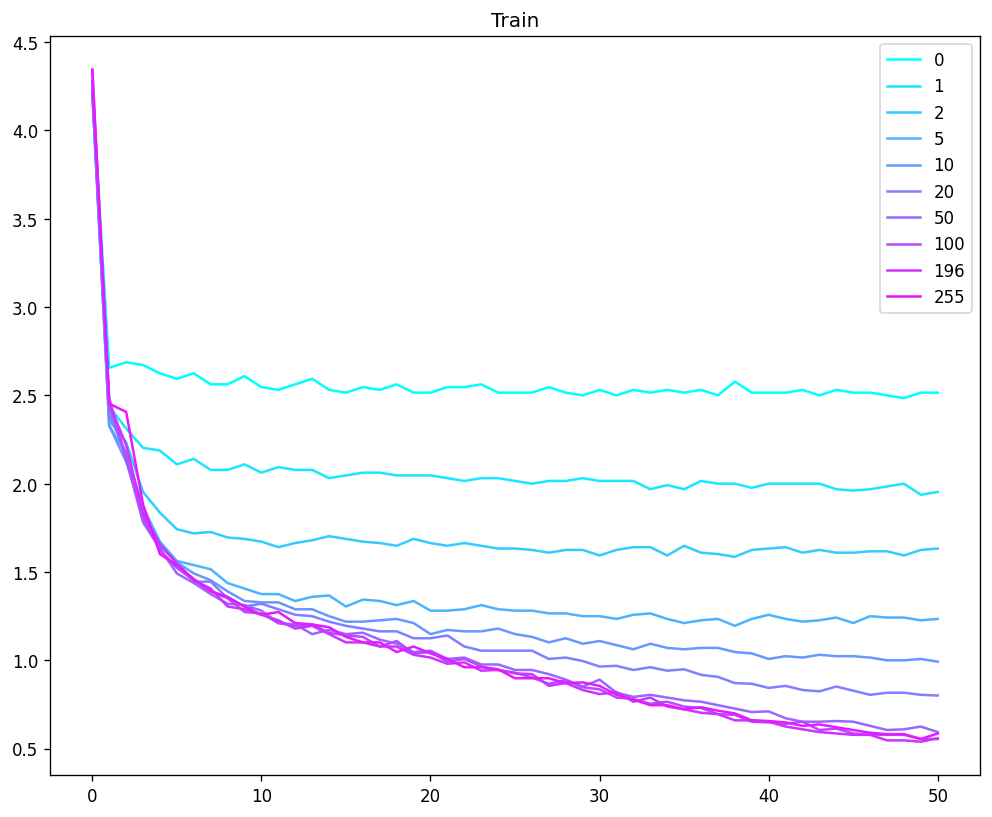

In [8]:
# # train_token_losses.shape
ids = [0, 1, 2, 5, 10, 20, 50, 100, 196, 255]
# ids = [0, 50, 250]
# plt.plot(train_token_losses[10].detach().float().cpu())

cmap = plt.get_cmap('cool')
plt.figure(figsize=(10, 8), dpi=120)
plt.title('Train')
for i, idx in enumerate(ids):
    plt.plot(train_token_losses[:, idx], label=idx, color=cmap(i/len(ids)))
plt.legend()
plt.show()






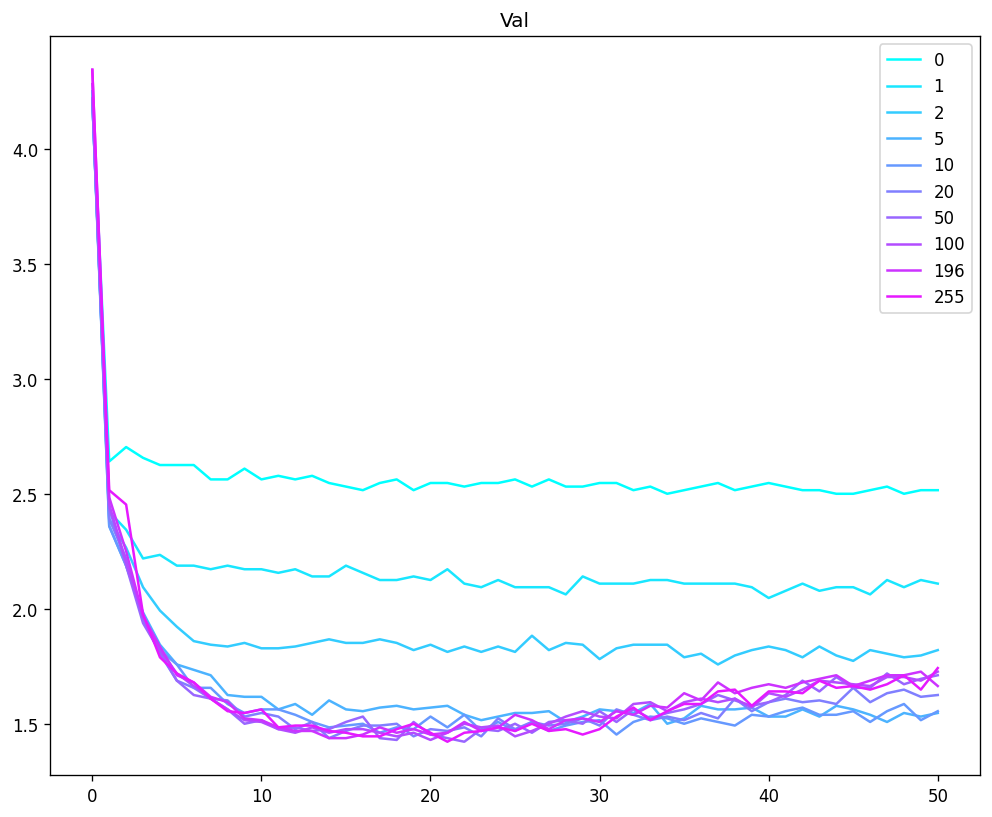

In [9]:
cmap = plt.get_cmap('cool')
plt.figure(figsize=(10, 8), dpi=120)
plt.title('Val')
for i, idx in enumerate(ids):
    plt.plot(val_token_losses[:, idx], label=idx, color=cmap(i/len(ids)))
plt.legend()
plt.show()



In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

10745088
